# Loading

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

url = os.chdir(r"/content/gdrive/MyDrive")
os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/MyDrive'

In [ ]:
os.chdir(r"/content/gdrive/MyDrive/laptop-price")

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df = pd.read_csv("Price_euros_train.csv")
df_test = pd.read_csv("Price_euros_test.csv")
# df = pd.concat([df_train, df_test]).reset_index(drop=True)


In [ ]:
# print(df_train.shape)
print(df_test.shape)
print(df.shape)

(195, 12)
(1108, 13)


#Info

In [ ]:
df.tail()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
1103,1315,Asus,X556UJ-XO044T (i7-6500U/4GB/500GB/GeForce,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,4GB,500GB HDD,Nvidia GeForce 920M,Windows 10,2.2kg,720.32
1104,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.00
1105,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.00
1106,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.00
1107,1320,Asus,X553SA-XX031T (N3050/4GB/500GB/W10),Notebook,15.6,1366x768,Intel Celeron Dual Core N3050 1.6GHz,4GB,500GB HDD,Intel HD Graphics,Windows 10,2.2kg,369.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1108 non-null   int64  
 1   Company           1108 non-null   object 
 2   Product           1108 non-null   object 
 3   TypeName          1108 non-null   object 
 4   Inches            1108 non-null   float64
 5   ScreenResolution  1097 non-null   object 
 6   Cpu               1108 non-null   object 
 7   Ram               1108 non-null   object 
 8   Memory            1108 non-null   object 
 9   Gpu               1108 non-null   object 
 10  OpSys             1055 non-null   object 
 11  Weight            1086 non-null   object 
 12  Price_euros       1108 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 112.7+ KB


# Data cleaning

In [ ]:
# df['Price_euros'].at[1114] = 973

In [ ]:
# screen resolution, делим отдельно на height и width, всё остальное нафиг
df_1 = df['ScreenResolution'].str.replace('x', ' ')
df_2 = df_1.str.split(' ')
height = pd.to_numeric(df_2.str[-2])
width = pd.to_numeric(df_2.str[-1])
df['Height'] = height
df['Width'] = width
df = df.drop(['ScreenResolution'], axis=1)

In [ ]:
# ram, убираем GB
df['Ram'] = df['Ram'].str.replace('GB', '').astype(int)

In [ ]:
# Memory, делим на объем (переводим тб в гб) и тип памяти (4 колонки тру/фолс)
pattern = '\d+\.?\d*\w{2}'

def convert_to_gb(value, unit):
        if unit.upper() == 'TB':
            return int(value * 1024)
        return int(value)

def find_pattern(string, pattern):
    if re.search(pattern, string):
        object = re.search(pattern, string).group(0).split()[0]
        value = object[:-2]
        unit = object[-2:]
        return convert_to_gb(float(value), unit)
    else:
        return 0

df['Storage'] = df['Memory'].apply(lambda x: find_pattern(x,pattern))

df['SSD'] = df['Memory'].str.contains('SSD')
df['HDD'] = df['Memory'].str.contains('HDD')
df['Hybrid'] = df['Memory'].str.contains('Hybrid')
df['Flash Storage'] = df['Memory'].str.contains('Flash Storage')

df = df.drop(['Memory'], axis=1)

In [ ]:
# weight, убираем килограммы
df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)

In [ ]:
# cpu, тоже отдельно GHz, отдельно модель (всё что не GHz)
def ext_cpu(cpu):
    match = re.findall(r'\d+\.?\d*GHz', cpu)
    ans, not_ans = map(str, match[0].split('GHz'))
    return pd.Series([float(ans)])

df[['Cpu_GHz']] = df['Cpu'].apply(ext_cpu)
df['Cpu_model'] = df['Cpu'].replace(to_replace=r'\s+\d+\.?\d*GHz', value='', regex=True)
df = df.drop(['Cpu'], axis=1)

In [ ]:
# смотрим процент пропусков
df_nan = df.isnull().sum()/df.shape[0] * 100
df_nan

,0
laptop_ID,0.000000
Company,0.000000
Product,0.000000
TypeName,0.000000
Inches,0.000000
Ram,0.000000
Gpu,0.000000
OpSys,4.783394
Weight,1.985560
Price_euros,0.000000


In [ ]:
# эти 3 заменяем средними значениями
mean_weight = df['Weight'].mean()
mean_height = df['Height'].mean()
mean_width = df['Width'].mean()

df['Weight']=df['Weight'].fillna(mean_weight)
df['Height']=df['Height'].fillna(mean_height)
df['Width']=df['Width'].fillna(mean_width)

# а этот модами по компаниям
df['temp'] = df.groupby('Company')['OpSys'].transform(lambda x: x.mode()[0])
df['OpSys'] = df['OpSys'].fillna(df['temp'])
df = df.drop('temp', axis=1)

In [ ]:
# дропнули айдишники
df = df.drop(['laptop_ID'], axis=1)

In [ ]:
# проверка на нормальность (нужна ли она вообще? мб нет, нафиг она)
# keys = list(df.select_dtypes(include='number').columns)

# fig, axes = plt.subplots(3, 4, figsize=(10, 10))
# # fig.set_size_inches(8 * len(keys), 4)
# axes = axes.flatten()

# for key, ax in zip(keys, axes):
#     ax.hist(df[key], density=True, bins=23)

#     loc = df[key].mean()
#     scale = df[key].std()

#     x_left, x_right = ax.get_xlim()
#     x = np.linspace(x_left, x_right, 10000)
#     y = stats.norm.pdf(x, loc=loc, scale=scale)

#     ax.plot(x, y, linestyle='dashed')
#     ax.set_title(key, fontsize=8)

# Correlogram

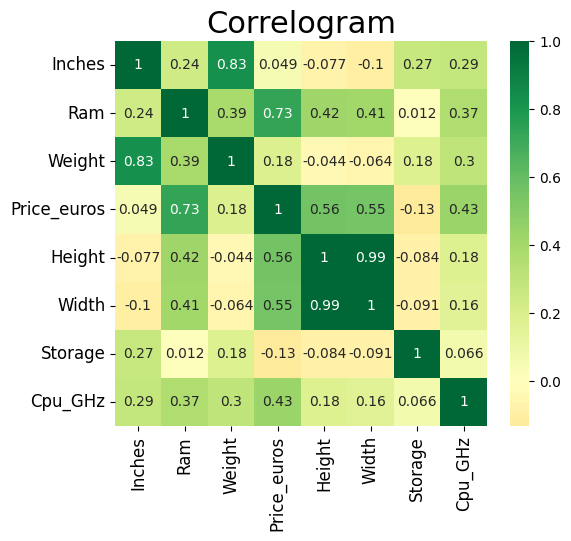

In [ ]:
df1 = df.drop(columns=['SSD', 'HDD', 'Hybrid', 'Flash Storage'])
plt.figure(figsize=(6,5))
sns.heatmap(df1.corr(numeric_only=True), xticklabels=df1.corr(numeric_only=True).columns, yticklabels=df1.corr(numeric_only=True).columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Correlogram', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# делаем из колонок width и height одну (среднее), потому что у них корелляция почти 1
df['Avg_res'] = (df['Width'] + df['Height'])/2
df = df.drop(['Width'], axis=1)
df = df.drop(['Height'], axis=1)

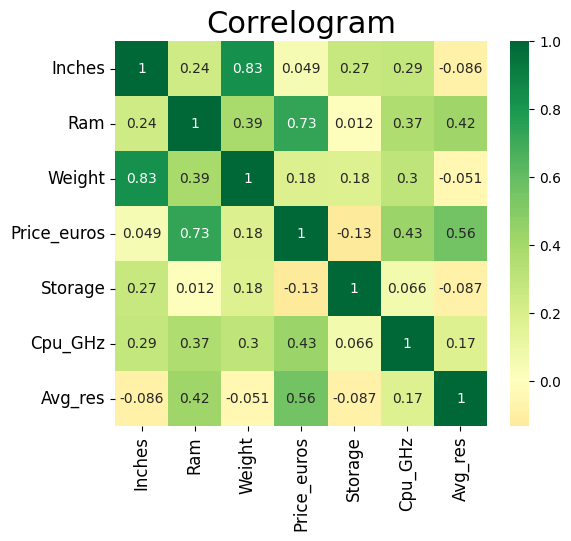

In [ ]:
df1 = df.drop(columns=['SSD', 'HDD', 'Hybrid', 'Flash Storage'])
plt.figure(figsize=(6,5))
sns.heatmap(df1.corr(numeric_only=True), xticklabels=df1.corr(numeric_only=True).columns, yticklabels=df1.corr(numeric_only=True).columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Correlogram', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Categorial features

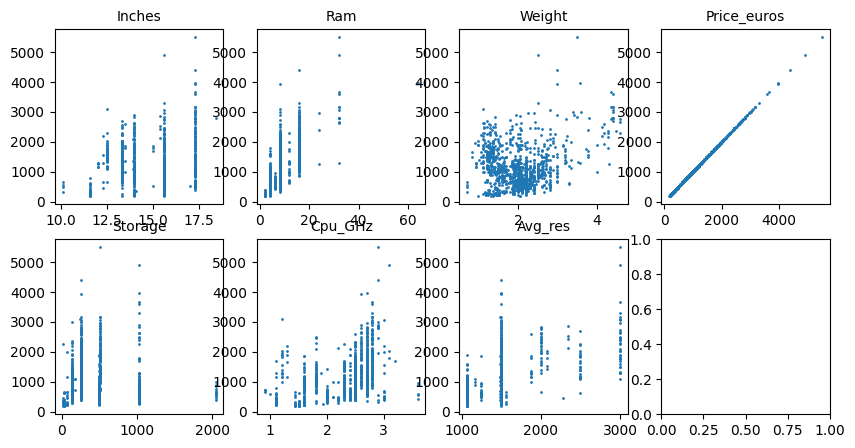

In [ ]:
# делим дф на числовые и нечисловые, для числовых строим графички
num_df = df.select_dtypes(include=np.number)
not_num_df = df.select_dtypes(exclude=np.number)
keys = list(num_df.columns)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()

for key, ax in zip(keys, axes):
  ax.scatter(num_df[key], num_df['Price_euros'], s=1)
  ax.set_title(key, fontsize=10)
# pair-plot

In [ ]:
not_num_df.head()

,Company,Product,TypeName,Gpu,OpSys,SSD,HDD,Hybrid,Flash Storage,Cpu_model
0,Apple,Macbook Air,Ultrabook,Intel HD Graphics 6000,macOS,False,False,False,True,Intel Core i5
1,Apple,MacBook Pro,Ultrabook,AMD Radeon Pro 455,macOS,True,False,False,False,Intel Core i7
2,Apple,MacBook Pro,Ultrabook,Intel Iris Plus Graphics 650,macOS,True,False,False,False,Intel Core i5
3,Acer,Aspire 3,Notebook,AMD Radeon R5,Windows 10,False,True,False,False,AMD A9-Series 9420
4,Apple,MacBook Pro,Ultrabook,Intel Iris Pro Graphics,Mac OS X,False,False,False,True,Intel Core i7


In [ ]:
print(not_num_df['Product'].nunique())
# бесполезно чё-то с ними пытаться делать, дропаем, да и зачем вообще нужно название, на что оно влияет
not_num_df = not_num_df.drop(['Product'], axis=1)

548


In [ ]:
# оставляем только фирму процессора (первое слово в строке)
not_num_df['cpu_brand'] = [x.split(' ')[0] for x in df['Cpu_model']]
not_num_df['cpu_brand'].unique()

array(['Intel', 'AMD', 'Samsung'], dtype=object)

In [ ]:
# делаем колонку с intel core отдельно, потому что их много
not_num_df['Intel_core'] = not_num_df['Cpu_model'].str.extract(r"(Intel Core i\d+)").fillna(0)

In [ ]:
# оставляем первое слово в строке у GIntel Core ipu, потому что дальше там всё непонятное
not_num_df['Gpu'] = [x.split(' ')[0] for x in df['Gpu']]
not_num_df['Gpu'].unique()

array(['Intel', 'AMD', 'Nvidia', 'ARM'], dtype=object)

In [ ]:
# этот столбец нам больше не нужен
not_num_df = not_num_df.drop(['Cpu_model'], axis=1)

not_num_df.head(10)

,Company,TypeName,Gpu,OpSys,SSD,HDD,Hybrid,Flash Storage,cpu_brand,Intel_core
0,Apple,Ultrabook,Intel,macOS,False,False,False,True,Intel,Intel Core i5
1,Apple,Ultrabook,AMD,macOS,True,False,False,False,Intel,Intel Core i7
2,Apple,Ultrabook,Intel,macOS,True,False,False,False,Intel,Intel Core i5
3,Acer,Notebook,AMD,Windows 10,False,True,False,False,AMD,0
4,Apple,Ultrabook,Intel,Mac OS X,False,False,False,True,Intel,Intel Core i7
5,Asus,Ultrabook,Nvidia,Windows 10,True,False,False,False,Intel,Intel Core i7
6,HP,Notebook,Intel,No OS,False,True,False,False,Intel,Intel Core i5
7,HP,Notebook,Intel,No OS,False,True,False,False,Intel,Intel Core i3
8,Apple,Ultrabook,AMD,macOS,True,False,False,False,Intel,Intel Core i7
9,Dell,Notebook,AMD,Windows 10,True,False,False,False,Intel,Intel Core i3


In [ ]:
# из наших обработанных категориальных признаков делаем столбцы нулей и единиц
not_num_df = pd.get_dummies(not_num_df).astype(float)

In [ ]:
# not_num_df = not_num_df.reset_index(drop=True)

In [ ]:
# not_num_df = not_num_df.drop(['Company_Huawei'], axis=1)
not_num_df

,SSD,HDD,Hybrid,Flash Storage,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,...,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,cpu_brand_AMD,cpu_brand_Intel,cpu_brand_Samsung,Intel_core_0,Intel_core_Intel Core i3,Intel_core_Intel Core i5,Intel_core_Intel Core i7
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1104,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1105,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1106,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df = pd.concat([num_df, not_num_df], axis=1)

In [ ]:
df.dtypes

,0
Inches,float64
Ram,int64
Weight,float64
Price_euros,float64
Storage,int64
Cpu_GHz,float64
Avg_res,float64
SSD,float64
HDD,float64
Hybrid,float64


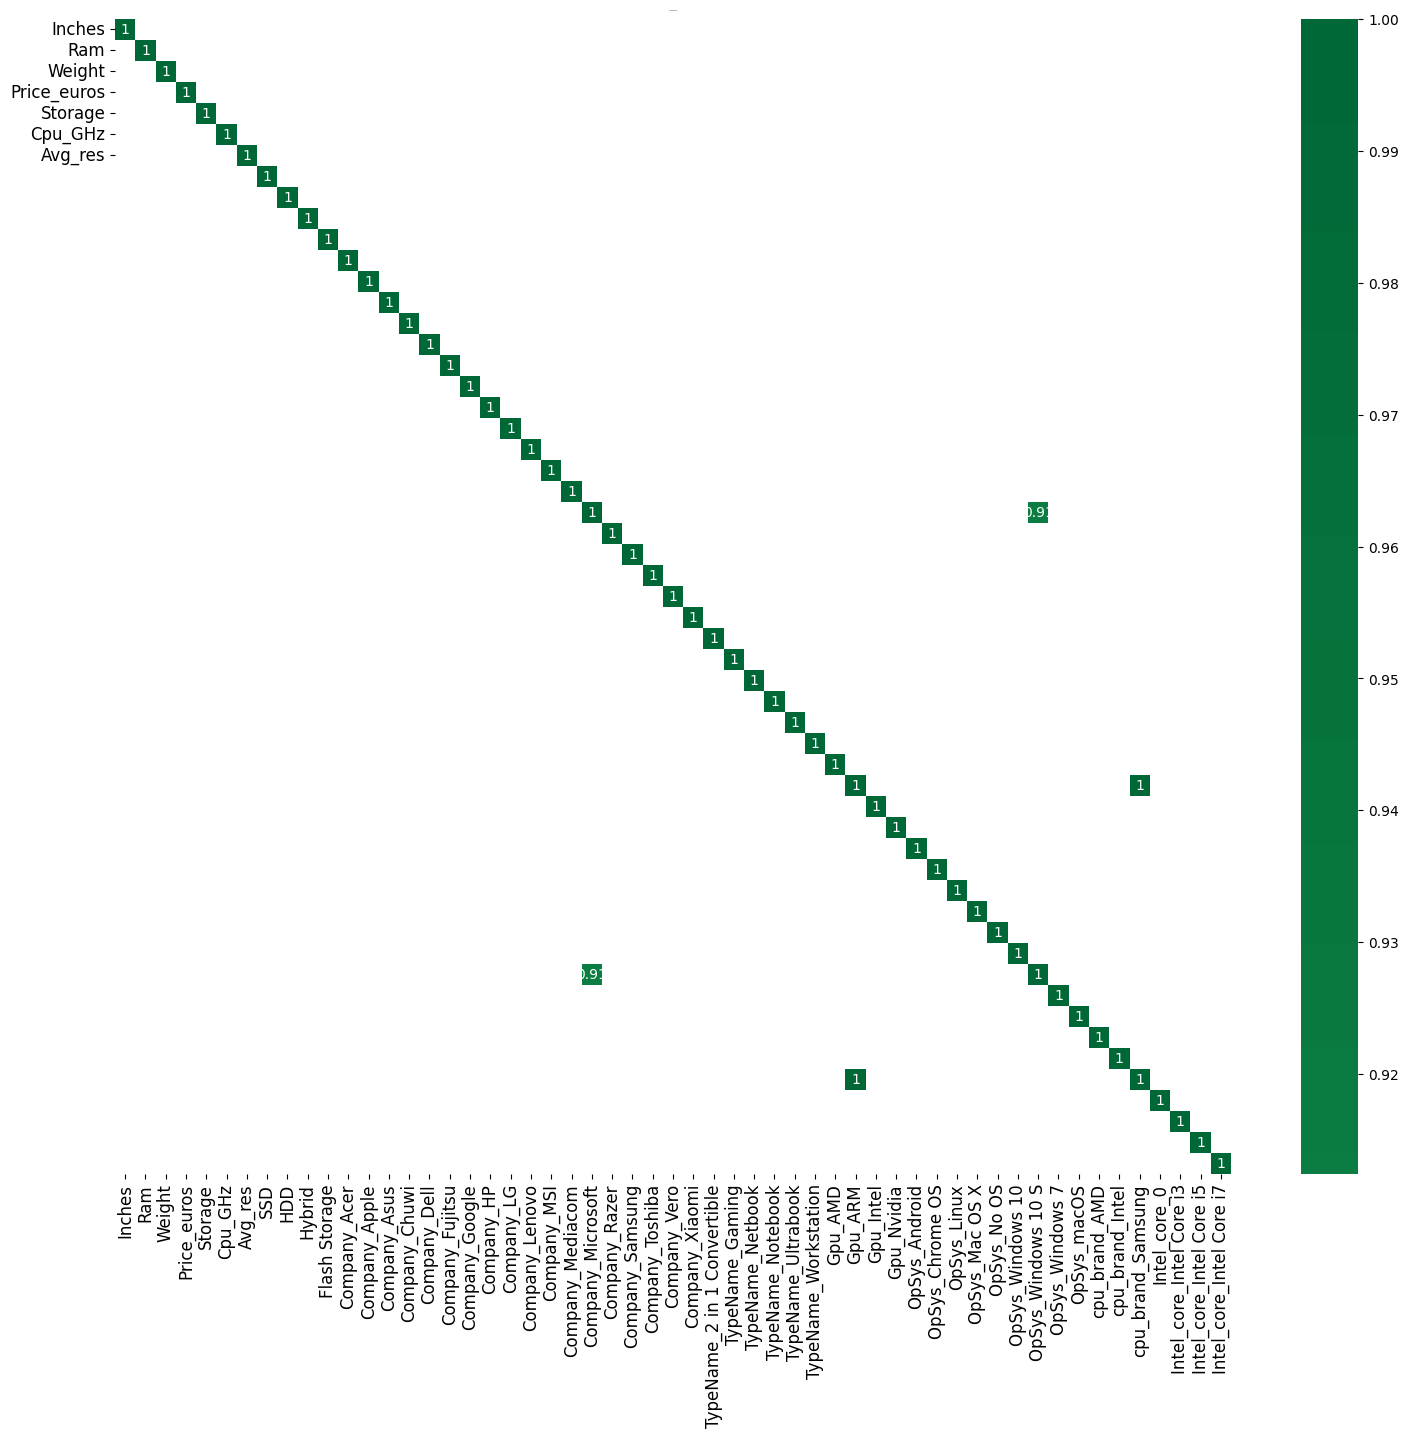

In [ ]:
plt.figure(figsize=(18,15))
corr = df.corr(numeric_only=True)
# np.fill_diagonal(corr.values, np.nan)
filter_corr = corr.where(corr >= 0.85).dropna(axis=1, how='all')
sns.heatmap(filter_corr, xticklabels=df.corr(numeric_only=True).columns, yticklabels=df1.corr(numeric_only=True).columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Correlogram', fontsize=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# убрать 1 переменную, найти переменные которые имеют большую крелляцию (фильтр)

In [ ]:
filter_corr

,Company_Microsoft,Gpu_ARM,OpSys_Windows 10 S,cpu_brand_Samsung
Inches,NaN,NaN,NaN,NaN
Ram,NaN,NaN,NaN,NaN
Weight,NaN,NaN,NaN,NaN
Price_euros,NaN,NaN,NaN,NaN
Storage,NaN,NaN,NaN,NaN
Cpu_GHz,NaN,NaN,NaN,NaN
Avg_res,NaN,NaN,NaN,NaN
SSD,NaN,NaN,NaN,NaN
HDD,NaN,NaN,NaN,NaN
Hybrid,NaN,NaN,NaN,NaN


In [ ]:
df = df.drop(['Company_Microsoft', 'cpu_brand_Samsung'], axis=1)

In [ ]:
df.head()

,Inches,Ram,Weight,Price_euros,Storage,Cpu_GHz,Avg_res,SSD,HDD,Hybrid,...,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,cpu_brand_AMD,cpu_brand_Intel,Intel_core_0,Intel_core_Intel Core i3,Intel_core_Intel Core i5,Intel_core_Intel Core i7
0,13.3,8,1.34,898.94,128,1.8,1170.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,15.4,16,1.83,2537.45,512,2.7,2340.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,13.3,8,1.37,1803.60,256,3.1,2080.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,15.6,4,2.10,400.00,500,3.0,1067.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,15.4,16,2.04,2139.97,256,2.2,2340.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Data scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X = df.drop(columns=['Price_euros'])
y = df['Price_euros']

std = StandardScaler()
X_norm = std.fit_transform(X)

X_norm = pd.DataFrame(X_norm, columns=X.columns)

# X_norm = pd.concat([X_norm_1, not_num_df], axis=1)

In [ ]:
X_norm

,Inches,Ram,Weight,Storage,Cpu_GHz,Avg_res,SSD,HDD,Hybrid,Flash Storage,...,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,cpu_brand_AMD,cpu_brand_Intel,Intel_core_0,Intel_core_Intel Core i3,Intel_core_Intel Core i5,Intel_core_Intel Core i7
0,-1.221219,-0.071167,-1.064608,-0.869482,-0.976340,-0.809369,-1.340888,-0.906845,-0.090495,4.005765,...,-2.177368,-0.073788,-0.180607,10.478550,-0.224136,0.226348,-0.44915,-0.350134,1.447402,-0.816190
1,0.258515,1.505896,-0.316339,0.179506,0.795916,2.241569,0.745775,-0.906845,-0.090495,-0.249640,...,-2.177368,-0.073788,-0.180607,10.478550,-0.224136,0.226348,-0.44915,-0.350134,-0.690893,1.225206
2,-1.221219,-0.071167,-1.018796,-0.519819,1.583585,1.563583,0.745775,-0.906845,-0.090495,-0.249640,...,-2.177368,-0.073788,-0.180607,10.478550,-0.224136,0.226348,-0.44915,-0.350134,1.447402,-0.816190
3,0.399442,-0.859699,0.095973,0.146725,1.386668,-1.077956,-1.340888,1.102724,-0.090495,-0.249640,...,0.459270,-0.073788,-0.180607,-0.095433,4.461576,-4.417977,2.22643,-0.350134,-0.690893,-0.816190
4,0.258515,1.505896,0.004348,-0.519819,-0.188671,2.241569,-1.340888,-0.906845,-0.090495,4.005765,...,-2.177368,-0.073788,-0.180607,-0.095433,-0.224136,0.226348,-0.44915,-0.350134,-0.690893,1.225206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,0.399442,-0.859699,0.248681,0.146725,0.402081,-1.077956,-1.340888,1.102724,-0.090495,-0.249640,...,0.459270,-0.073788,-0.180607,-0.095433,-0.224136,0.226348,-0.44915,-0.350134,-0.690893,1.225206
1104,-0.727974,-0.859699,-0.362151,-0.869482,0.402081,0.051152,0.745775,-0.906845,-0.090495,-0.249640,...,0.459270,-0.073788,-0.180607,-0.095433,-0.224136,0.226348,-0.44915,-0.350134,-0.690893,1.225206
1105,-0.727974,-1.253965,-0.820276,-1.044313,-1.370175,-1.077956,-1.340888,-0.906845,-0.090495,4.005765,...,0.459270,-0.073788,-0.180607,-0.095433,-0.224136,0.226348,2.22643,-0.350134,-0.690893,-0.816190
1106,0.399442,-0.465433,0.233410,1.578155,0.402081,-1.077956,-1.340888,1.102724,-0.090495,-0.249640,...,0.459270,-0.073788,-0.180607,-0.095433,-0.224136,0.226348,-0.44915,-0.350134,-0.690893,1.225206


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.15, random_state=42)

# X_train = X_norm.iloc[0:1108]
# X_train = pd.concat([X_train, X_norm.iloc[[1114]]], ignore_index=True)
# y_train = y[0:1108]
# y_train = np.append(y_train, y[1114])
# X_test = X_norm[1108:1305]
# np.delete(X_test, 1114)
# y_test = y[1108:1305]

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Test dataset size: {X_test.shape}')
# print(X_norm.iloc[1114])
# вывести веса

Train dataset size: (941, 52), (941,)
Test dataset size: (167, 52)


# Model

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)
# y_pred_adekvat = np.delete(y_pred, [6, 106])
# mean = y_pred_adekvat.mean()
# y_pred[6] = mean
# y_pred[106] = mean

In [ ]:
coefficients = model.coef_
coeff_df = pd.DataFrame({'признак': X.columns, 'коэф': coefficients})
coeff_df

,признак,коэф
0,Inches,-2.424611e+01
1,Ram,2.867770e+02
2,Weight,8.978021e+01
3,Storage,1.940607e+01
4,Cpu_GHz,1.067422e+02
5,Avg_res,1.307048e+02
6,SSD,1.039498e+02
7,HDD,1.583406e+01
8,Hybrid,4.862465e+00
9,Flash Storage,8.326920e+00


In [ ]:
# df1 = pd.DataFrame(y_pred)
# df1['index'] = df1.index
# df1['Price_euros'] = df1[0]
# df1 = df1.drop([0], axis=1)
# df1.to_csv('output.csv', index=False)
# df1

# metrics

In [ ]:
from sklearn import metrics

print("MAE", metrics.mean_absolute_error(y_test, y_pred))
print("MSE", metrics.mean_squared_error(y_test, y_pred))
print("R2 Score:", model.score(X_test, y_test))

# MAE 252.42183806373117
# MSE 122101.24745512646
# R2 Score: 0.7615780387875617

MAE 252.49037908228001
MSE 122172.51451812986
R2 Score: 0.7614388785964475


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [ ]:
lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, X, y, cv=kf, scoring='r2')
scores

# array([0.77423861, 0.75110621, 0.73718636, 0.70079204, 0.76488428])

array([0.77423861, 0.75110621, 0.73666614, 0.70105106, 0.76488428])

In [ ]:
# 471,Lenovo,Thinkpad P51,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7820HQ 2.9GHz,8GB,256GB SSD,Nvidia Quadro M2200M,Windows 10,2.67kg
# 828,Dell,Latitude 3480,Notebook,14.0,1366x768,Intel Core i5 6200U 2.3GHz,4GB,500GB HDD,Intel HD Graphics 520,Windows 10,1.76kg
